In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'whole_gen_12_1_simpler'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [72]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [73]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
sample_data = sample_data[sample_data['before'].str.len() > 0]
sample_data = sample_data[sample_data['before'].str.len() <= 31]
# sample_data = sample_data[sample_data['class'] != 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 653598,  (dropped rows: 9264594)


In [71]:
tmp = sample_data[sample_data['before'].str.len() > 30]
tmp.groupby('class')['class'].count()

class
ELECTRONIC    731
LETTERS         1
NUMBERS        14
Name: class, dtype: int64

In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NUMBERS', 'PLAIN', 'VERBATIM']
5


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 1351])

### More balanced sample

In [100]:
import collections

balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

last_samples = collections.deque(maxlen=100)
balanced_data_last_sample = last_samples

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org


def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
        
    sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    last_samples.append(sample)
    balanced_data_last_sample = sample
    return sample
    
balanced_data_randomize()

In [23]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC     4964
LETTERS       20000
NUMBERS       20000
PLAIN         20000
VERBATIM      11741
Name: class, dtype: int64

In [25]:
balanced_data_sample_row()

sentence_id                                               586402
token_id                                                      18
class                                                      PLAIN
before                                                        mt
after                                                      mount
class_org                                                  PLAIN
a_word_ind                                              [169, 0]
sentence       king sejo healed his own skin problems at bany...
Name: 512491, dtype: object

### Samples

In [26]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence'].split(' ')
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

VERBATIM : & -> and <EOS> [55, 0]
['cum', 'gratia', '<SAMPLE>', 'priuilegio', 'regis', '.']
torch.Size([1, 2, 104])


In [27]:
%%timeit
get_random_sample()

147 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [28]:
use_cuda = True

In [29]:
MAX_ATTENTION_LENGTH = 30

In [30]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
# tmp[~tmp['before'].str.contains('/')].sample(2)

746

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
557156,636804,18,ELECTRONIC,http://www.mcu.usmc.mil/historydivision/Pages/...,h t t p colon slash slash w w w dot m c u dot ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...",marine corps history division http : / / www ....
177662,204144,19,ELECTRONIC,http://www.calabasashistoricalsociety.org/City...,h t t p colon slash slash w w w dot c a l a b ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","hogle , gene nac green book of pacific coast t..."


### Encoder

In [31]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.GRU(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.GRU(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = hidden_words.view(1, -1)
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = hidden_chars.view(1, -1)
        
        #hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        #for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
        #    hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)

        all_outputs_chars_padded = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        att_length = min(len(all_outputs_chars[0]), MAX_ATTENTION_LENGTH-1)
        all_outputs_chars_padded[0:att_length] = all_outputs_chars[0][0:att_length]
        
        output = torch.cat((output_words, output_chars), 1)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, all_outputs_chars_padded

    def init_hidden(self):
        var1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1 = var1.cuda(); var2 = var2.cuda()
        return (var1, var2)
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn

EncoderRNN (
  (rnn_words): GRU(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): GRU(104, 128, batch_first=True, bidirectional=True)
)

In [32]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    #s_bef, s_aft, s_class, s_sentence = get_random_sample(True)
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(tmp_encoder_output, tmp_encoder_outputs), tmp = test_encoder_single_sample()
tmp
tmp_encoder_output.size()
tmp_encoder_outputs.size()

:


':'

torch.Size([1, 384])

torch.Size([30, 256])

### Decoder

In [33]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, chars_encoded_size,
                 n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = nn.Linear(self.hidden_size+self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size+chars_encoded_size, self.hidden_size)
        
        #self.module_attn = torch.nn.ModuleList([self.emb_lin, self.dropout, self.attn, self.attn_combine])
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)
        
        #self.module_rnn = torch.nn.ModuleList([self.rnn, self.lin_out])

    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        embedded = embedded[0]
                
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        #return embedded, attn_applied
        
        rnn_input = torch.cat((embedded, attn_applied[0]), 1)
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        rnn_input = F.relu(rnn_input)
    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden[0], attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        
    def mods_split(self):
        mods = list(decoder_rnn.modules())[1:]
        for gru_index, mod in enumerate(mods):
            #print(mod)
            if type(mod) == torch.nn.modules.rnn.GRU:
                break
        return mods[:gru_index], mods[gru_index:]
        
    def mods_attn(self):
        return self.mods_split()[0]
        
    def mods_gru(self):
        return self.mods_split()[1]

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=tmp_encoder_output.size()[1],
                         chars_encoded_size=tmp_encoder_outputs.size()[1], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_encoder_output, tmp_encoder_outputs)
#tmp
[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (1351 -> 384)
  (dropout): Dropout (p = 0.1)
  (attn): Linear (768 -> 30)
  (attn_combine): Linear (640 -> 384)
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
)

[torch.Size([1, 1351]), torch.Size([1, 384]), torch.Size([1, 30])]

In [34]:
tmp = [{'params': mod.parameters(), 'lr': 3} for mod in decoder_rnn.mods_attn()]
tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
tmp.append(
    {'params': encoder_rnn.parameters()}
)
tmp

[{'lr': 3, 'params': <generator object Module.parameters at 0x7fdbea1dc360>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7fdbec7d13b8>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7fdbe2d45ba0>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7fdbed6ac888>},
 {'params': <generator object Module.parameters at 0x7fdbe321feb8>},
 {'params': <generator object Module.parameters at 0x7fdbe8ff4468>},
 {'params': <generator object Module.parameters at 0x7fdbe2e27728>}]

# Training etc

### Accuracy

In [35]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    decoder_input = Variable(sos_tensor).cuda()
    decoder_hidden = encoder_output
    
    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('barbeque sim of of of of of of of of of of of of of of of of of of',
 'barbeque sim of of of of of of of of of of of of of of of of of of',
 'p',
 ('P.',
  [24, 0],
  'LETTERS',
  ['571998',
   'the',
   'distribution',
   'of',
   'welfare',
   'and',
   'household',
   'production',
   ':',
   'international',
   'perspectives',
   '(',
   'stephen',
   '<SAMPLE>',
   'jenkins',
   ',',
   'arie',
   'kapteyn',
   ',',
   'bernard',
   'm',
   '.',
   's',
   '.',
   'van',
   'praag',
   ',',
   'eds',
   '.']))

In [83]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        after = ' '.join([words_after_common[i] for i in s_aft[0:-1]])
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, after, '', s_sentence, ))
print_local_wrong_predictions(2)

http://www.iisg.nl/archives/en/files/i/10886062.phpBaraheni => h w t t dot w w w dot i s n slash dot g s dash s s h || h t t p colon slash slash w w w dot i i s g dot n l slash a r c h i v e s slash e n slash f i l e s slash i slash o n e o e i g h t e i g h t s i x o s i x t w o dot p h p b a r a h e n i 
                  ['writers', 'association', 'of', 'iran', ':', '<SAMPLE>', ',', 'reza', '(', '2005', ')', '.']
mobilised      => publicized     || mobilized 
                  ['since', 'the', 'murder', 'was', 'motivated', 'by', 'racism', ',', 'it', '<SAMPLE>', 'large', 'parts', 'of', 'the', 'norwegian', 'population', '.']


In [37]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.07 s, sys: 20 ms, total: 2.09 s
Wall time: 2.09 s


0.0

### Training

In [44]:
def train(s_bef, s_aft, s_sentence, optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    global encoder_output, encoder_outputs
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda() 
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    target_arr = s_aft
    optimizer.zero_grad()
    loss = 0
    
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    
    decoder_hidden = encoder_output
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()
    
    # not used yet
    # https://github.com/pytorch/examples/blob/master/word_language_model/main.py
    clip_parameters_value = 0.25
    if clip_parameters_value:
        for m in [decoder_rnn, encoder_rnn]:
            torch.nn.utils.clip_grad_norm(m.parameters(), clip_parameters_value)

    optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [40]:
tmp = [op for op in decoder_rnn.parameters()]

In [ ]:
tmp[0].min()

In [ ]:
[len(op['params']) for op in optimizer.param_groups]

In [ ]:
1+1

In [41]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):
    global optimizer
    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    tmp = [{'params': mod.parameters(), 'lr': (lr/10)} for mod in decoder_rnn.mods_attn()]
    tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
    tmp.append(
        {'params': encoder_rnn.parameters()}
    )
    optimizer = torch.optim.Adam(tmp, lr=lr)
    
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             optimizer=optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [42]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_12_1_simpler


In [45]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

    10  18% (   0m 0s)   7.205   |   7.17: st -> mcm mcm (✗: saint) 
Saved model to data/models/whole_gen_12_1_simpler/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    19  36% (  3m 31s)   7.179   |   7.13: organised -> recolonization (✗: organized) 
    28  54% (  3m 31s)   6.785   |   1.79: 1968 ->  (✗: nineteen sixty eight) 
    37  72% (  3m 31s)   6.045   |   3.64: Centre ->  (✗: center) 
    46  90% (  3m 31s)   5.885   |   3.60: bros ->  (✗: brothers) 


In [46]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   551  53% (   0m 6s)   3.388   |   4.87: MTV -> and <EOS> <EOS> (✗: m t v) (forcing)


In [47]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 15s)   2.691   |   1.04: Goal.com -> nineteen (✗: g o a l dot c o m) 
  3000  22% (  0m 31s)   2.460   |   2.69: jr -> saint (✗: junior) (forcing)
  4000  33% (  0m 47s)   2.367   |   2.72: 23 March 1939 -> the twenty of of twenty twenty (✗: the twenty third of march nineteen thirty nine) 
  5000  44% (   1m 3s)   2.252   |   4.58: December 12, 2012 -> the twenty of twenty twenty (✗: december twelfth twenty twelve) (forcing)
  6000  56% (  1m 19s)   2.115   |   2.55: IA -> p (✗: i a) 
  7000  67% (  1m 34s)   1.968   |   4.70: 5.7% -> nineteen s <EOS> <EOS> (✗: five point seven percent) (forcing)
  8000  78% (  1m 50s)   1.951   |   2.25: C.A. -> p s (✗: c a) (forcing)
  9000  89% (   2m 7s)   1.897   |   3.39: 460 -> u hundred three (✗: four hundred sixty) (forcing)
 10000 100% (  2m 25s)   1.872   |   1.69: colour -> center (✗: color) (forcing)


In [48]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  2m 58s)   0.696   |   0.00: ISBN -> i s b n (✓) (forcing)
 30000  22% (  5m 49s)   0.509   |   0.53: LAUSD -> l a u s <EOS> (✗: l a u s d) (forcing)
 40000  33% (  8m 50s)   0.442   |   0.00: Theatre -> theater (✓) (forcing)
 50000  44% ( 11m 47s)   0.325   |   0.00: Scoop.co.nz -> s c o o p dot c o dot n z (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/50000_(EncoderRNN/DecoderRNN)
Accuracy: 88.65% (    8865/   10000)
 60000  56% ( 15m 39s)   0.356   |   0.00: FutureSource.com -> f u t u r e s o u r c e dot c o m (✓) 
 70000  67% ( 18m 43s)   0.213   |   1.13: IFLA's -> i f l l a's (✗: i f l a's) 
 80000  78% ( 21m 46s)   0.225   |   0.00: dr -> doctor (✓) 
 90000  89% ( 24m 50s)   0.217   |   0.00: Ibu -> i b u (✓) 
100000 100% ( 27m 42s)   0.209   |   4.62: modernisation -> saint (✗: modernization) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/100000_(EncoderRNN/DecoderRNN)
Accuracy: 92.54% (    9254/   10000)


In [49]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000   5% (  2m 56s)   0.199   |   0.00: # -> number (✓) (forcing)
120000  10% (  5m 47s)   0.213   |   0.00: & -> and (✓) 
130000  15% (  8m 46s)   0.252   |   0.00: sq -> square (✓) (forcing)
140000  20% ( 11m 42s)   0.174   |   0.00: & -> and (✓) 
150000  25% ( 14m 34s)   0.222   |   0.01: CALISMALAR -> c a l i s m a l a r (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/150000_(EncoderRNN/DecoderRNN)
Accuracy: 93.09% (    9309/   10000)
160000  30% ( 18m 13s)   0.252   |   0.00: M. -> m (✓) (forcing)
170000  35% (  21m 4s)   0.176   |   0.00: Centre -> center (✓) 
180000  40% ( 23m 57s)   0.230   |   0.00: GVK -> g v k (✓) 
190000  45% ( 26m 48s)   0.243   |   0.00: jr -> junior (✓) 
200000  50% ( 29m 44s)   0.271   |   0.00: Scrum.com -> s c r u m dot c o m (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/200000_(EncoderRNN/DecoderRNN)
Accuracy: 92.49% (    9249/   10000)
210000  55% ( 33m 29s)   0.197   |   0.00: CEV -> c e v (✓) 
220000  60% ( 36m

IndexError: list index out of range

In [52]:
len(last_samples[-2]['before'])

209

In [87]:
state_dict_path = 'data/models/whole_gen_12_1_simpler/250000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
# sample_data = sample_data[sample_data['before'].str.len() <= 31]

In [85]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

286765   5% (  2m 51s)   0.233   |   0.00: CSDSD -> c s d s d (✓) (forcing)
296765  10% (  5m 48s)   0.279   |   0.00: & -> and (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/300000_(EncoderRNN/DecoderRNN)
Accuracy: 93.19% (    9319/   10000)
306765  15% (  9m 31s)   0.206   |   0.00: 119 -> one hundred nineteen (✓) (forcing)
316765  20% ( 12m 30s)   0.323   |   0.00: 2013 -> twenty thirteen (✓) 
326765  25% ( 15m 25s)   0.256   |   0.00: VPS -> v p s (✓) (forcing)
336765  30% ( 18m 25s)   0.370   |   0.00: st -> saint (✓) 


IndexError: list index out of range

In [92]:
state_dict_path = 'data/models/whole_gen_12_1_simpler/300000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [93]:
len(last_samples[-2]['before'])

302

In [91]:
len(balanced_data)

76705

In [94]:
len(balanced_data[balanced_data['before'].str.len()>100])

106

In [97]:
# running balanced_data stuff again so its reseted

In [102]:
len(balanced_data[balanced_data['before'].str.len()>100])

0

In [103]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

346957  10% (  2m 34s)   0.192   |   0.00: 2004 -> two thousand four (✓) 
Saved model to data/models/whole_gen_12_1_simpler/350000_(EncoderRNN/DecoderRNN)
Accuracy: 93.88% (    9388/   10000)
356957  20% (  5m 56s)   0.262   |   0.00: GOSAT -> g o s a t (✓) (forcing)
366957  30% (  8m 31s)   0.257   |   0.00: 90% -> ninety percent (✓) 
376957  40% (  11m 5s)   0.248   |   0.00: pp -> p p (✓) (forcing)
386957  50% ( 13m 39s)   0.207   |   0.00: March 2012 -> march twenty twelve (✓) (forcing)
396957  60% ( 16m 13s)   0.279   |   0.00: III -> three (✓) 
Saved model to data/models/whole_gen_12_1_simpler/400000_(EncoderRNN/DecoderRNN)
Accuracy: 92.51% (    9251/   10000)
406957  70% (  20m 1s)   0.217   |   0.00: & -> and (✓) 
416957  80% ( 22m 32s)   0.230   |   0.00: - -> to (✓) 
426957  90% (  25m 5s)   0.283   |   0.53: 6' -> six (✗: six feet) 
436957 100% ( 27m 44s)   0.245   |   0.00: - -> to (✓) (forcing)


In [104]:
print_local_wrong_predictions()

~              => tilde          || to 
                  ['2004', ':', 'february', '5', '<SAMPLE>', '15', ',', 'banqiao', 'city', ',', 'taipei', 'county', '(', 'now', 'is', 'banqiao', 'district', ',', 'new', 'taipei', 'city', ')', '.']
st             => street         || saint 
                  ['entries', 'played', '18', 'holes', 'at', 'prince', "'s", 'and', '18', 'holes', 'at', 'royal', '<SAMPLE>', 'george', "'s", '.', 'the', 'top', '100', 'and', 'ties', 'qualified', '.']
uclabruins.com => u c l a b r u i n dot u c o m dot c o m || u c l a b r u i n s dot c o m 
                  ['bruins', 'homepage', '"', '<SAMPLE>', 'retrieved', 'on', 'october', '1', ',', '2008', '.']
Burnsbog.org   => b u r n s b o dot e o r g || b u r n s b o g dot o r g 
                  ['<SAMPLE>', 'archived', 'december', '17', ',', '2013', ',', 'at', 'the', 'wayback', 'machine', '.']
50th           => five           || fiftieth 
                  ['"', 'miles', 'revisited', ':', 'sketches', 'of', 'spain',

In [126]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.0001)

446957  10% (  2m 38s)   0.230   |   0.00: PDF -> p d f (✓) 
Saved model to data/models/whole_gen_12_1_simpler/450000_(EncoderRNN/DecoderRNN)
Accuracy: 92.89% (    9289/   10000)
456957  20% (   6m 6s)   0.254   |   3.20: Malayalamcinema.com -> m a l a y a l a a c u n n m a i n v m a (✗: m a l a y a l a m c i n e m a dot c o m) 
466957  30% (  8m 41s)   0.238   |   0.00: theatre -> theater (✓) (forcing)
476957  40% ( 11m 14s)   0.216   |   0.00: 8.1 -> eight point one (✓) 
486957  50% ( 13m 50s)   0.171   |   1.19: MtShastaNews.com -> m t s h a s t a n e w s e e s s (✗: m t s h a s t a n e w s dot c o m) 
496957  60% ( 16m 26s)   0.179   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_12_1_simpler/500000_(EncoderRNN/DecoderRNN)
Accuracy: 94.61% (    9461/   10000)
506957  70% ( 19m 51s)   0.150   |   0.00: 500 -> five hundred (✓) 
516957  80% ( 22m 25s)   0.151   |   0.00: sq -> square (✓) (forcing)
526957  90% (  25m 2s)   0.180   |   0.00: # -> number (✓) (forcing)
536957

In [128]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.0001)

546957  10% (  2m 33s)   0.149   |   0.00: 14 -> fourteen (✓) 
Saved model to data/models/whole_gen_12_1_simpler/550000_(EncoderRNN/DecoderRNN)
Accuracy: 94.94% (    9494/   10000)
556957  20% (  5m 52s)   0.179   |   0.00: 1925 -> nineteen twenty five (✓) 
566957  30% (  8m 23s)   0.132   |   0.00: & -> and (✓) 
576957  40% ( 10m 55s)   0.152   |   0.00: 9 September 1977 -> the ninth of september nineteen seventy seven (✓) 
586957  50% ( 13m 25s)   0.172   |   0.00: # -> number (✓) (forcing)
596957  60% ( 15m 57s)   0.143   |   0.00: - -> to (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/600000_(EncoderRNN/DecoderRNN)
Accuracy: 95.17% (    9517/   10000)
606957  70% ( 19m 22s)   0.145   |   0.00: vol -> volume (✓) 
616957  80% (  22m 0s)   0.159   |   0.00: 10.0% -> ten point zero percent (✓) (forcing)
626957  90% ( 24m 32s)   0.176   |   0.00: : -> to (✓) (forcing)
636957 100% (  27m 4s)   0.144   |   0.00: UN -> u n (✓) (forcing)


In [129]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.0001)

646957  10% (  2m 32s)   0.139   |   0.00: June 3, 2012 -> june third twenty twelve (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/650000_(EncoderRNN/DecoderRNN)
Accuracy: 95.41% (    9541/   10000)
656957  20% (  5m 50s)   0.096   |   0.00: & -> and (✓) 
666957  30% (  8m 23s)   0.124   |   0.00: - -> to (✓) 
676957  40% ( 10m 54s)   0.115   |   0.00: & -> and (✓) 
686957  50% ( 13m 26s)   0.080   |   0.00: organisation -> organization (✓) (forcing)
696957  60% ( 15m 56s)   0.123   |   2.92: $161.03bn -> one hundred sixty one point one billion dollars (✗: one hundred sixty one point o three billion dollars) 
Saved model to data/models/whole_gen_12_1_simpler/700000_(EncoderRNN/DecoderRNN)
Accuracy: 95.32% (    9532/   10000)
706957  70% ( 19m 14s)   0.111   |   0.00: APH -> a p h (✓) 
716957  80% ( 21m 44s)   0.179   |   0.00: recognisable -> recognizable (✓) 
726957  90% ( 24m 13s)   0.152   |   0.00: Centre -> center (✓) (forcing)
736957 100% ( 26m 45s)   0.117   |  

In [130]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

746957  10% (  2m 31s)   0.108   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_12_1_simpler/750000_(EncoderRNN/DecoderRNN)
Accuracy: 95.23% (    9523/   10000)
756957  20% (  5m 54s)   0.117   |   0.00: 30 January -> the thirtieth of january (✓) 
766957  30% (  8m 27s)   0.138   |   0.00: UK -> u k (✓) 
776957  40% ( 10m 59s)   0.112   |   0.00: # -> number (✓) 
786957  50% ( 13m 31s)   0.126   |   0.00: ALH -> a l h (✓) 
796957  60% (  16m 5s)   0.129   |   0.00: 10.3% -> ten point three percent (✓) 
Saved model to data/models/whole_gen_12_1_simpler/800000_(EncoderRNN/DecoderRNN)
Accuracy: 95.56% (    9556/   10000)
806957  70% ( 19m 27s)   0.130   |   0.00: 15 -> fifteen (✓) 
816957  80% (  22m 1s)   0.116   |   0.00: 2007 -> two thousand seven (✓) (forcing)
826957  90% ( 24m 36s)   0.097   |   0.00: st -> saint (✓) 
836957 100% (  27m 7s)   0.113   |   0.00: & -> and (✓) 


In [131]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

846957  10% (  2m 30s)   0.113   |   0.00: metres -> meters (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/850000_(EncoderRNN/DecoderRNN)
Accuracy: 96.12% (    9612/   10000)
856957  20% (  5m 52s)   0.105   |   0.00: ATOMAL -> a t o m a l (✓) (forcing)
866957  30% (  8m 24s)   0.138   |   0.00: popularised -> popularized (✓) 
876957  40% (  11m 7s)   0.104   |   0.00: 13th -> thirteenth (✓) (forcing)
886957  50% ( 13m 44s)   0.148   |   0.00: mr -> mister (✓) (forcing)
896957  60% ( 16m 23s)   0.099   |   0.00: December 17, 2009 -> december seventeenth two thousand nine (✓) 
Saved model to data/models/whole_gen_12_1_simpler/900000_(EncoderRNN/DecoderRNN)
Accuracy: 95.85% (    9585/   10000)
906957  70% (  20m 0s)   0.102   |   0.00: organisation -> organization (✓) 
916957  80% ( 22m 45s)   0.087   |   0.00: etc -> etcetera (✓) 
926957  90% ( 25m 22s)   0.113   |   0.00: - -> to (✓) 
936957 100% (  28m 6s)   0.103   |   1.99: #NU065 -> hash four o five five (✗: hash n

In [132]:
print_local_wrong_predictions()

hr             => hour           || h r 
                  ['in', '1997', ',', '<SAMPLE>', 'baty', 'won', 'the', 'kosice', 'challenger', 'title', 'defeating', 'nicolas', 'lapentti', '.']
Operissimo.comKlaus => o              || o p e r i s s i m o dot c o m k l a u s 
                  ['<SAMPLE>', 'ulrich', 'spiegel', ':', '"', 'la', 'voix', 'de', 'corse', '.']
monopolised    => x              || monopolized 
                  ['his', 'socialist', 'activism', '<SAMPLE>', 'his', 'time', ',', 'forcing', 'him', 'to', 'abandon', 'a', 'translation', 'of', 'the', 'persian', 'shahnameh', '.']
flavouring     => twenty l a v o u r i i g || flavoring 
                  ['it', 'is', 'used', 'as', 'a', 'dessert', '<SAMPLE>', 'for', 'malasadas', ',', 'cheesecakes', ',', 'cookies', ',', 'ice', 'cream', 'and', 'mochi', '.']
socialisation  => of             || socialization 
                  ['they', 'tend', 'to', 'assign', 'to', 'them', ',', 'for', 'functional', 'purposes', ',', 'the', 'role', 'of'

In [133]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

946957  10% (  2m 39s)   0.236   |   0.00: Theatre -> theater (✓) 
Saved model to data/models/whole_gen_12_1_simpler/950000_(EncoderRNN/DecoderRNN)
Accuracy: 92.97% (    9297/   10000)
956957  20% (  6m 12s)   0.324   |   0.00: BPS -> b p s (✓) 
966957  30% (  8m 54s)   0.279   |   2.38: IX -> the first (✗: the ninth) 
976957  40% ( 11m 31s)   0.233   |   0.00: CCi -> c c i (✓) 
986957  50% ( 14m 12s)   0.294   |   0.00: $ -> dollar (✓) 
996957  60% ( 16m 57s)   0.248   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1000000_(EncoderRNN/DecoderRNN)
Accuracy: 92.25% (    9225/   10000)
1006957  70% ( 20m 34s)   0.307   |   0.00: 50 -> fifty (✓) 
1016957  80% ( 23m 18s)   0.211   |   1.32: 2007-10-13 -> the thirteenth of october (✗: the thirteenth of october two thousand seven) 
1026957  90% (  26m 1s)   0.269   |   4.31: 2014-05-24 -> the twenty of april twenty fourteen (✗: the twenty fourth of may twenty fourteen) 
1036957 100% ( 28m 45s)   0.255   |   0.00: _ 

In [134]:
print_local_wrong_predictions()

honouring      => honor          || honoring 
                  ['essays', '<SAMPLE>', 'ervin', 'laszlo', ',', 'pp', '.']
cand.mag       => c a n d dot a a g || c a n d dot m a g 
                  ['he', 'graduated', 'as', '<SAMPLE>', '.']
2010s          => twenty seventies || twenty tens 
                  ['in', 'the', '<SAMPLE>', ',', 'cars', 'are', 'increasingly', 'sold', 'with', 'remote', 'control', 'door', 'locks', '.']
1914           => nineteen fourteen || one thousand nine hundred fourteen 
                  ['sepoys', 'in', 'the', 'trenches', ':', 'the', 'indian', 'corps', 'on', 'the', 'western', 'front', ',', '<SAMPLE>', '-', '1915', '.']
timber.coastal => t i m b e l dot c o a v t a d s d || t i m b e r dot c o a s t a l 
                  ['shrimp', ',', 'salt', ',', 'tobacco', ',', 'ground', 'nut', ',', 'mustard', 'seed', ',', 'flour', ',', 'water', 'melon', ',', '<SAMPLE>', 'fish', '.']
WGBH's         => w g b h        || w g b h's 
                  ['"', 'faculty', 'm

In [135]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

1046957   5% (  2m 40s)   0.258   |   0.00: 14 -> fourteen (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1050000_(EncoderRNN/DecoderRNN)
Accuracy: 93.18% (    9318/   10000)
1056957  10% (   6m 7s)   0.265   |   0.00: - -> to (✓) 
1066957  15% (  8m 41s)   0.221   |   0.00: AAP -> a a p (✓) 
1076957  20% ( 11m 17s)   0.182   |   0.00: ITB -> i t b (✓) 
1086957  25% ( 13m 57s)   0.170   |   0.00: 2009 -> two thousand nine (✓) 
1096957  30% ( 16m 32s)   0.157   |   0.00: # -> hash (✓) (forcing)
Saved model to data/models/whole_gen_12_1_simpler/1100000_(EncoderRNN/DecoderRNN)
Accuracy: 93.85% (    9385/   10000)
1106957  35% (  20m 0s)   0.237   |   0.00: & -> and (✓) 
1116957  40% ( 22m 48s)   0.206   |   0.00: 1837 -> eighteen thirty seven (✓) 
1126957  45% ( 25m 32s)   0.163   |   0.00: min -> minute (✓) (forcing)
1136957  50% (  28m 9s)   0.184   |   0.00: & -> and (✓) 
1146957  55% ( 30m 50s)   0.138   |   0.00: BBC -> b b c (✓) 
Saved model to data/models/whole_gen_12_1_sim

In [136]:
print_local_wrong_predictions()

autoblog.comPemberton => a u t o b l o g dot c o m || a u t o b l o g dot c o m p e m b e r t o n 
                  ['cougar', 'ace', 'salvage', 'operation', 'turns', 'deadly', 'at', '<SAMPLE>', ',', 'mary', '(', '2006', '-', '08', '-', '01', ')', '.']
TheRecordHerald.com => t h e r e c o r d h e e o n o dot e o m n || t h e r e c o r d h e r a l d dot c o m 
                  ['"', 'dr', 'francis', 'achampong', 'returns', 'to', 'penn', 'state', 'mont', 'alto', 'as', 'chancellor', ',', '"', '<SAMPLE>', '.']
DisneyInsider.com => d i s n e y i n e i d e dot n dot e e o r || d i s n e y i n s i d e r dot c o m 
                  ['<SAMPLE>', '(', 'the', 'walt', 'disney', 'company', ')', '.']
March 1949     => march nineteen forty three || march nineteen forty nine 
                  ['in', '<SAMPLE>', ',', 'the', 'committee', 'of', 'the', 'royal', 'academy', 'in', 'england', 'accepted', 'the', 'works', 'annigoni', 'offered', 'for', 'its', 'annual', 'exhibition', '.']
1449966373     => th

In [137]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

1246957   3% (  2m 29s)   0.138   |   0.00: 12 -> twelve (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1250000_(EncoderRNN/DecoderRNN)
Accuracy: 94.47% (    9447/   10000)
1256957   7% (  5m 47s)   0.139   |   0.00: SXSW -> s x s w (✓) 
1266957  10% (  8m 18s)   0.172   |   0.00: March 12, 2013 -> march twelfth twenty thirteen (✓) 
1276957  13% ( 10m 47s)   0.134   |   0.00: W.H. -> w h (✓) (forcing)
1286957  17% ( 13m 17s)   0.219   |   5.43: ST -> saint t (✗: s t) (forcing)
1296957  20% ( 15m 46s)   0.175   |   0.00: # -> number (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1300000_(EncoderRNN/DecoderRNN)
Accuracy: 95.36% (    9536/   10000)
1306957  23% (  19m 5s)   0.140   |   0.63: Blabbermouth.net -> b l a b b e r m o u t h dot n dot t t (✗: b l a b b e r m o u t h dot n e t) 
1316957  27% ( 21m 34s)   0.124   |   0.00: 4 -> four (✓) 
1326957  30% (  24m 5s)   0.128   |   0.00: April 12, 2011 -> april twelfth twenty eleven (✓) (forcing)
1336957  33% ( 26m 37s)  

In [138]:
print_local_wrong_predictions()

tuttoabruzzo.it => t u t t o a b r z z z o dot c z o e i t i || t u t t o a b r u z z o dot i t 
                  ['the', 'stone', 'city', '(', '1999', ')', '(', 'isbn', '978', '-', '0', '-', '7544', '-', '0098', '-', '1', ')', '(', '15', 'december', '2008', ')', '"', 'doktoro', 'esperanto', '"', ',', 'stasera', 'al', 'museo', 'colonna', 'di', 'pescara', ',', '<SAMPLE>', '.']
HonestReporting.comBackground => h o n e s t r e p o r g m e c c c g c c || h o n e s t r e p o r t i n g dot c o m b a c k g r o u n d 
                  ['not', 'an', '"', 'apartheid', 'wall', '"', 'on', '<SAMPLE>', 'info', ':', 'the', 'security', 'fence', 'on', 'imra', '.', 'org', '.', 'ilis', 'israel', "'s", 'security', 'barrier', 'unique', '?']
4/5            => four a         || four fifths 
                  ['louis', 'proyect', ',', 'nicaragua', ',', 'about', '<SAMPLE>', 'of', 'the', 'way', 'down', '.']
#getcorrected  => hash tag thirteen || hash tag getcorrected 
                  ['"', 'is', 'turnham', 

In [139]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1546957   3% (  2m 28s)   0.189   |   0.00: RS -> r s (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1550000_(EncoderRNN/DecoderRNN)
Accuracy: 95.00% (    9500/   10000)
1556957   7% (  5m 46s)   0.073   |   0.00: jr -> junior (✓) 
1566957  10% (  8m 15s)   0.100   |   0.00: US -> u s (✓) 
1576957  13% ( 10m 43s)   0.114   |   0.00: .ifr -> dot i f r (✓) 
1586957  17% ( 13m 14s)   0.111   |   0.00: : -> to (✓) 
1596957  20% ( 15m 44s)   0.176   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1600000_(EncoderRNN/DecoderRNN)
Accuracy: 95.44% (    9544/   10000)
1606957  23% (  19m 2s)   0.139   |   0.00: _ -> underscore (✓) 
1616957  27% ( 21m 32s)   0.145   |   0.00: PDF -> p d f (✓) 
1626957  30% (  24m 2s)   0.166   |   0.00: MS -> m s (✓) 
1636957  33% ( 26m 31s)   0.097   |   0.00: K.V. -> k v (✓) 
1646957  37% (  29m 1s)   0.104   |   0.00: DC -> d c (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1650000_(EncoderRNN/DecoderRNN)
Accuracy: 95

In [140]:
print_local_wrong_predictions()

Baseball-Reference.com => b a s e b a l l a s r a l d a s dot r t n || b a s e b a l l d a s h r e f e r e n c e dot c o m 
                  ['"', 'jarrod', 'dyson', 'statistics', 'and', 'history', '—', '<SAMPLE>', '"', '.']
39-68.in       => r nine d d t i i i i i i i i i i i i i i i || t h i r t y n i n e d a s h s i x t y e i g h t dot i n 
                  ['journal', 'of', 'contemporary', 'history', '(', '1990', ')', '25', '#', '1', 'pp', ':', '<SAMPLE>', 'j', 'storleslie', 'king', ',', '"', "'", 'france', 'needs', 'children', "'", '"', 'sociological', 'quarterly', '(', '1998', ')', '39', '#', '1', 'pp', ':', '33', '-', '52', '.']
Calciomercato.it => c a l c i o m e r o a t o dot || c a l c i o m e r c a t o dot i t 
                  ['<SAMPLE>', '(', 'in', 'italian', ')', '.']
42             => forty two      || four two 
                  ['"', 'ward', 'information', 'for', 'stranmillis', 'ward', '95', 'gg', '<SAMPLE>', '"', '.']
Multicolour    => tumor          || multicolor

In [189]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

1846957   5% (   3m 6s)   0.145   |   0.00: theatres -> theaters (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1850000_(EncoderRNN/DecoderRNN)
Accuracy: 95.58% (    9558/   10000)
1856957  10% (  6m 53s)   0.155   |   2.49: 2.10.1.1 -> t w one e e v e e e e e dot e e dot e (✗: t w o dot t e n dot o n e dot o n e) 
1866957  15% (  9m 45s)   0.150   |   0.00: - -> to (✓) (forcing)
1876957  20% ( 12m 37s)   0.132   |   0.00: 17 January 2006 -> the seventeenth of january two thousand six (✓) 
1886957  25% ( 15m 30s)   0.103   |   0.00: & -> and (✓) 
1896957  30% ( 18m 22s)   0.167   |   0.00: DX -> d x (✓) 
Saved model to data/models/whole_gen_12_1_simpler/1900000_(EncoderRNN/DecoderRNN)
Accuracy: 95.68% (    9568/   10000)
1906957  35% (  22m 6s)   0.127   |   0.00: Theatre -> theater (✓) 
1916957  40% ( 24m 57s)   0.089   |   0.00: 1970 -> nineteen seventy (✓) 
1926957  45% ( 27m 49s)   0.121   |   0.00: & -> and (✓) 
1936957  50% ( 30m 40s)   0.105   |   0.00: Ancestry.com -> a

In [190]:
print_local_wrong_predictions()

0071546383     => o o seven one five four six three eight || o o seven one five four six three eight three 
                  ['isbn', '<SAMPLE>', ',', 'isbn', '978', '-', '0', '-', '07', '-', '154638', '-', '6', '.']
ChildTrends.org => c h i l d t r e n d s dot o r r r h o r g || c h i l d t r e n d s dot o r g 
                  ['<SAMPLE>', ',', 'last', 'updated', 'july', '2014', '.']
UKGameshows.com => u k g a m e s h h s s h c o m || u k g a m e s h o w s dot c o m 
                  ['5', '-', 'star', 'family', 'reunion', 'at', '<SAMPLE>', '.']
1988           => nineteen eighty eight || one thousand nine hundred eighty eight 
                  ['four', 'new', 'players', '—', 'gérard', 'buscher', ',', 'merry', 'krimau', ',', 'thierry', 'fernier', 'and', 'sonny', 'silooy', '—', 'were', 'signed', 'for', 'the', '1987', '-', '<SAMPLE>', 'season', '.']
BaseCampMD.com => b a s e c a m p m o o c o m || b a s e c a m p m d dot c o m 
                  ['everest', 'bc', 'clinic', ',', '<SA

In [191]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

2046957   2% (  2m 50s)   0.118   |   0.00: Organisation -> organization (✓) 
Saved model to data/models/whole_gen_12_1_simpler/2050000_(EncoderRNN/DecoderRNN)
Accuracy: 95.87% (    9587/   10000)
2056957   4% (  6m 35s)   0.153   |   0.00: mt -> mount (✓) 
2066957   6% (  9m 27s)   0.128   |   0.00: 1906 -> nineteen o six (✓) 
2076957   8% ( 12m 18s)   0.142   |   0.00: & -> and (✓) 
2086957  10% (  15m 7s)   0.130   |   0.00: criticised -> criticized (✓) 
2096957  12% ( 17m 57s)   0.144   |   0.00: FCA -> f c a (✓) 
Saved model to data/models/whole_gen_12_1_simpler/2100000_(EncoderRNN/DecoderRNN)
Accuracy: 95.32% (    9532/   10000)
2106957  14% ( 21m 42s)   0.130   |   0.00: - -> to (✓) 
2116957  16% ( 24m 32s)   0.094   |   0.00: : -> to (✓) 
2126957  18% ( 27m 24s)   0.115   |   0.00: jr -> junior (✓) 
2136957  20% ( 30m 16s)   0.102   |   0.00: & -> and (✓) 
2146957  22% (  33m 5s)   0.194   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_12_1_simpler/2150000_(Encode

In [192]:
print_local_wrong_predictions()

ustravelweather.com => u s t r a v e l w e a t h e m r a h e m || u s t r a v e l w e a t h e r dot c o m 
                  ['"', 'average', 'weather', 'for', 'cairo', ',', 'il', '"', ',', 'weather', '.', 'com', '"', 'chicago', 'weather', '"', ',', 'ustravelweather', '.', 'com', '"', '"', ',', 'weather', '.', 'com', '"', 'moline', 'weather', '"', ',', 'ustravelweather', '.', 'com', '"', 'peoria', 'weather', '"', ',', 'ustravelweather', '.', 'com', '"', 'rockford', 'weather', '"', ',', '<SAMPLE>', '"', 'springfield', 'weather', '"', ',', 'ustravelweather', '.', 'comtammy', 'webber', '(', 'the', 'associated', 'press', ')', '(', '2002', '-', '01', '-', '13', ')', '.']
Avesta.orgBeyond => a v e s t a dot o r g b e y o n dot o y l || a v e s t a dot o r g b e y o n d 
                  ['isbn', '0', '-', '8010', '-', '2160', '-', 'x', ',', '9780801021602', 'vendidad', '1', ',', 'at', '<SAMPLE>', 'is', 'arachosia', ',', '36', 'schoeni', '.']
1-84309-164    => one sil eight four three sil ni

In [193]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.00005)

2546957   2% (  2m 48s)   0.117   |   0.00: NoviList.hr -> n o v i l i s t dot h r (✓) 
Saved model to data/models/whole_gen_12_1_simpler/2550000_(EncoderRNN/DecoderRNN)
Accuracy: 95.91% (    9591/   10000)
2556957   4% (  6m 31s)   0.106   |   0.00: mr -> mister (✓) 
2566957   6% (  9m 20s)   0.086   |   0.00: behaviour -> behavior (✓) 
2576957   8% (  12m 8s)   0.133   |   0.00: # -> number (✓) 
2586957  10% ( 14m 58s)   0.163   |   0.00: & -> and (✓) 
2596957  12% ( 17m 48s)   0.183   |   0.00: cDNA -> c d n a (✓) 
Saved model to data/models/whole_gen_12_1_simpler/2600000_(EncoderRNN/DecoderRNN)
Accuracy: 95.45% (    9545/   10000)
2606957  14% ( 21m 34s)   0.129   |   0.00: - -> to (✓) 
2616957  16% ( 24m 25s)   0.174   |   0.00: - -> to (✓) 
2626957  18% ( 27m 15s)   0.135   |   0.00: vs -> versus (✓) 
2636957  20% (  30m 6s)   0.079   |   0.00: 1953 -> nineteen fifty three (✓) 
2646957  22% ( 32m 56s)   0.118   |   0.00: 2007-01-23 -> the twenty third of january two thousand seve

In [194]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.00005)

3046957   2% (   3m 2s)   0.112   |   0.00: Plc -> p l c (✓) 
Saved model to data/models/whole_gen_12_1_simpler/3050000_(EncoderRNN/DecoderRNN)
Accuracy: 96.31% (    9631/   10000)
3056957   4% (  6m 59s)   0.113   |   0.00: ABC's -> a b c's (✓) 
3066957   6% (  10m 3s)   0.088   |   0.00: JM -> j m (✓) 
3076957   8% ( 13m 11s)   0.101   |   0.00: jr -> junior (✓) 
3086957  10% ( 16m 17s)   0.131   |   0.00: SMAC -> s m a c (✓) 
3096957  12% ( 19m 25s)   0.070   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_12_1_simpler/3100000_(EncoderRNN/DecoderRNN)
Accuracy: 96.25% (    9625/   10000)
3106957  14% ( 23m 25s)   0.135   |   0.00: RCA -> r c a (✓) 
3116957  16% ( 26m 28s)   0.081   |   5.95: 1914 -> nineteen fourteen (✗: one thousand nine hundred fourteen) 
3126957  18% ( 29m 31s)   0.121   |   0.00: G. -> g (✓) 
3136957  20% ( 32m 35s)   0.116   |   0.00: H. -> h (✓) 
3146957  22% ( 35m 35s)   0.125   |   0.00: Hitlistan.se -> h i t l i s t a n dot s e (✓) 
Saved model t

In [ ]:
bbb

In [ ]:
state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1400000_'
#state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1150000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
balanced_data_randomize = balanced_data_randomize_org
balanced_data_randomize()

In [ ]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=10000)

In [ ]:
clip_parameters_value = 0.2

In [ ]:
train_iterations(n_iters=100, print_every=50, teacher_forcing_ratio=0.2, lr=0.0001)

In [ ]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=1000)

In [ ]:
balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=400000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

### Show attention

In [ ]:
balanced_data.sample(5)

In [ ]:
balanced_data.groupby('class')['class'].count()
len(balanced_data)

In [ ]:
def balanced_data_randomize_long():
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    
    bal_data = pd.concat([v.sample(min(2000, len(v))) for k, v in balanced_data_classes_select])
    long_data = sample_data[sample_data['before'].str.len()>8].sample(4000)
    elec_data = sample_data[sample_data['class']=='ELECTRONIC']
    let_long_data = sample_data[(sample_data['class'] == 'LETTERS') & (sample_data['before'].str.len() > 5)]
    balanced_data = pd.concat([bal_data, long_data, elec_data, let_long_data])#.drop_duplicates()
    balanced_data = balanced_data[~balanced_data.index.duplicated(keep='first')]
    
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.5
    balanced_data_accessed_counter = 0

balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

input:   -
output:  ['to']
target:    to


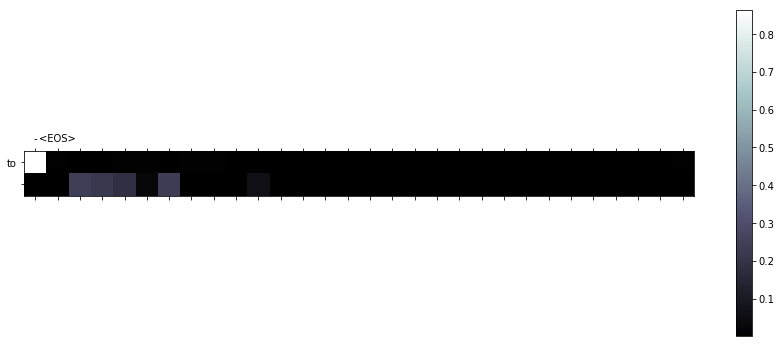

In [188]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    #inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    inp_arr = input_sentence
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    sample_row = balanced_data_sample_row()
    #sample_row = balanced_data[balanced_data['before'].str.len()>15].sample(1).iloc[0]
    sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence'].split(' ')

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [ ]:
balanced_data.groupby('class')['class'].unique()

In [ ]:
def test_in_categories(iter_len = 1000):
    wrong_preds = {}
    for cat in categories_all:
        tmp_data = sample_data[sample_data['class'] == cat].sample(iter_len)
        correct_n = 0
        wrong_preds_arr = []

        for _ in range(iter_len):
            sample_row = tmp_data.iloc[_]
            sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

            output, t1, sample_target, t2 = test_model_single_sample(None, sample=sample)
            if output == sample_target:
                correct_n += 1
            else:
                wrong_preds_arr.append([sample_target, output])

        print("{:>10}: {:>5d}/{:>5d} ({:>4.0%})".format(cat, correct_n, iter_len, correct_n/iter_len))
        wrong_preds[cat] = wrong_preds_arr
    return wrong_preds

In [ ]:
wrong_preds = test_in_categories(3000)

In [ ]:
wrong_preds['LETTERS']

In [ ]:
# With training longer words
wrong_preds = test_in_categories()